<a href="https://colab.research.google.com/github/balogun99/Deep-Convolutional-Generative-Adversarial-Networks/blob/main/Generate_Handwritten_Images_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Installing the Dependencies**

In [ ]:
!pip install tensorflow imageio tensorflow-docs

In [ ]:
import glob # used to match the patterns
import imageio # used for reading & writing images
import matplotlib.pyplot as plt # used to display te images
import numpy as np # used for scientific calculations of arrays & matrices
import os # used to navigate to our directory
import PIL # used to display images
import tensorflow as tf #
from tensorflow.keras import layers
import time # find how time it takes for each epoch training

from IPython import display # used to display the images in the epochs

# **Loading the MNIST Handwritten Digits Datasets**

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [1,-1]

In [ ]:
train_images.shape

(60000, 28, 28, 1)

In [ ]:
BUFFER_SIZE = 60000 # is used to shuffle our data
BATCH_SIZE = 256

In [ ]:
60000/256

234.375

In [ ]:
# Batch and Shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
print(train_dataset)

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>


In [ ]:
noise = tf.random.normal([1,100])

In [ ]:
print(len(noise[0]))

100


# **Creating the model**

## **Generator**

In [ ]:
def make_generator_model(): # get a random input and generate the image
  model=tf.keras.Sequential() # start the model sequentially
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape == (None, 7, 7, 256) # None is the batch size

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1,1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1,(5, 5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


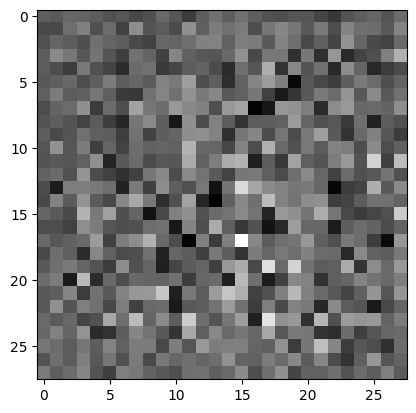

In [ ]:
# using the untrained generator to generate an image from random noise
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Descriminator

In [ ]:
def make_descriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                      input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [ ]:
# using the untrained descriminator to predict whether an image is real or fake
descriminator = make_descriminator_model()
decision = descriminator(generated_image)
print(decision)

tf.Tensor([[0.00080582]], shape=(1, 1), dtype=float32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Loss and Optimizer

In [ ]:
# This method returns an helper function to compute cross_entropy_loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## **Descriminator Loss**

### This method quantifies how well the descriminator is able to distinguish real images from fakes. It compares the descriminator's predictions on real images to an array of 1s, and the descriminators predictions on fake(generated) images to an array of 0s

In [ ]:
def descriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output) # True labels
  fake_output = cross_entropy(tf.zeros_like(fake_output), fake_output) # Predicted Labels
  total_loss = real_loss + fake_output
  return total_loss

## Generator Loss

### The generator's loss quantifies how well it is was able to work to the descriminator. Intuitively, if the generator is performing well, the descriminator would classify the fake images as real (or 1). Here, compare the descriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

### The descrimiator and the generator optimizers are different since the two(2) neueral networks would be train separately

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
descriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## **Saving the checkpoints**

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "chkpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 descriminator_optimizer=descriminator_optimizer,
                                 generator=generator,
                                 descriminator=descriminator)

## **Define the training loops**

In [ ]:
EPOCHS = 5 #100
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

### The training loops begins with generator receiving a random seed as input. That seed is used to produce an image. The descriminator is then used to classify real images (drawn from the training set) and fake images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and descriminator.

In [ ]:
@tf.function # decreated function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = descriminator(images, training=True)
        fake_output = descriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = descriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_descriminator = disc_tape.gradient(disc_loss, descriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    descriminator_optimizer.apply_gradients(zip(gradients_of_descriminator, descriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

    # produce images for the GIF
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                            epoch +1,
                            seed)
    # Save the model after 15 seconds
    if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    print("Time for Epochs {} is {} sec".format(epoch +1, time.time() - start))

    # Generate the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)

## Generate and Save Image

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]): # type: ignore
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i :, :, 0] * 127.5 + 127.5, cmap='gray') # type: ignore
        plt.axis('off')

        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()

## Training the model

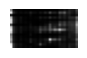

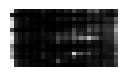

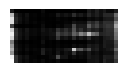

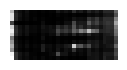

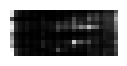

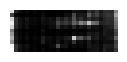

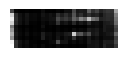

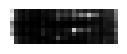

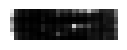

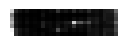

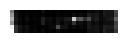

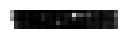

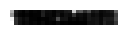

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
import PIL.Image


def display_image(epoch_no):
  filename = f'image_at_epoch_{epoch_no:04d}.png'
  return PIL.Image.open(filename)
    # return PIL.Image.open('Image_at_epoch{epoch_no:04d}.png').format(epoch_no)

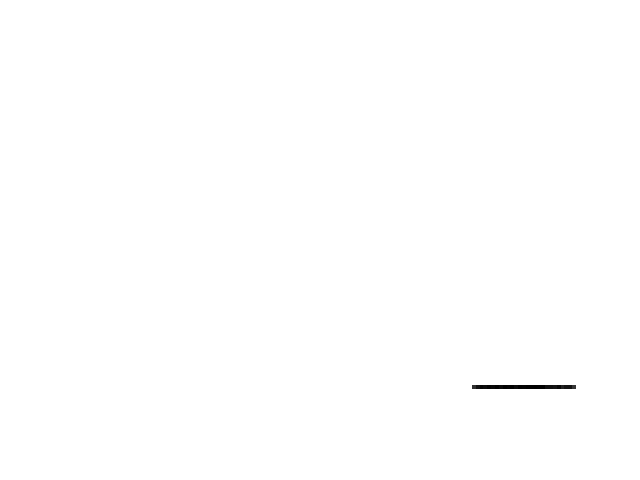

In [ ]:
display_image(EPOCHS)

## Use imageio to create an animated gif using the images saved during training

In [ ]:
main_file = 'dcgan.gif'

with imageio.get_writer(main_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)

  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-119-003e95785b27>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-119-003e95785b27>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



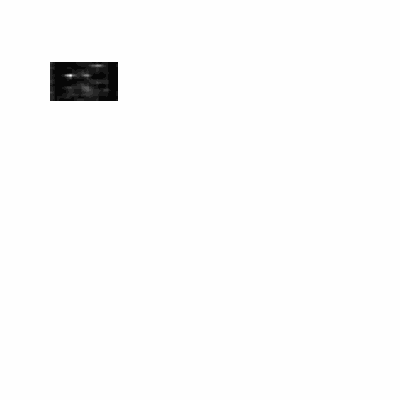

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(main_file)